In [36]:
import seaborn as sns
import scipy
import skimage
sns.set_style("ticks")
from pathlib import Path

# Get the data 

In [37]:
# in this file is the url to the spreadsheet with the data
# PIGLEG_SPREADSHEET_URL=https://docs.google.com/spreadsheets/d/1G55kXxcJ0...piLaK0snddRU-jzU/edit?usp=sharing
env_paths = list(Path(".").glob("../**/.env.dev"))
print(env_paths)
# find line with PIGLEG_SPREADSHEET_URL and give me the value after the "="
PIGLEG_SPREADSHEET_URL = [line.split("=", 1)[1].strip() for line in open(env_paths[0], "r") if line.startswith("PIGLEG_SPREADSHEET_URL")][0]
PIGLEG_SPREADSHEET_URL = PIGLEG_SPREADSHEET_URL.replace("\"", "")
PIGLEG_SPREADSHEET_URL = PIGLEG_SPREADSHEET_URL.replace("edit?usp=sharing", "export?format=csv")
# PIGLEG_SPREADSHEET_URL

[PosixPath('../.env.dev')]


In [38]:
import pandas as pd
url = PIGLEG_SPREADSHEET_URL
df = pd.read_csv(url)

In [39]:
df.tail()

,filename,report_url,timestamp,email,uploaded_at,finished_at,fps,Needle holder length [m],Scissors length [m],Forceps length [m],...,Stitch 3 duration [s],Stitch 3 duration [%],Needle holder stitch 0 length [pix],Forceps stitch 0 length [pix],Scissors stitch 0 length [pix],Needle holder bbox stitch 0 length [pix],Forceps bbox stitch 0 length [pix],Scissors bbox stitch 0 length [pix],Left hand bbox stitch 0 length [pix],Right hand bbox stitch 0 length [pix]
944,Bad-2021_11_03_A_Noll_Alexander_Einzelknopfnah...,http://suran.kky.zcu.cz:8000//uploader/web_rep...,2024-01-17 09:23:34,khalatbari.sadaf@gmail.com,2022-07-07 17:08,2024-01-17 08:23,25.0,"9,503007304","0,5081350784","1,944407215",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
945,Good-03_11_2021_B_Holzmu_ller_Katharina_Einzel...,http://suran.kky.zcu.cz:8000//uploader/web_rep...,2024-01-17 09:26:38,khalatbari.sadaf@gmail.com,2022-07-07 17:03,2024-01-17 08:26,25.0,"6,082319172","0,2729317353","1,19984709",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
946,Good-Einzelknopfnaht_Stoklossa.mp4,http://suran.kky.zcu.cz:8000//uploader/web_rep...,2024-01-17 09:31:14,khalatbari.sadaf@gmail.com,2022-06-20 08:55,2024-01-17 08:31,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
947,Bad-03_11_21_B_Hopfe_Johanna_Einzelknopfnaht.mp4,http://suran.kky.zcu.cz:8000//uploader/web_rep...,2024-01-17 09:37:24,khalatbari.sadaf@gmail.com,2022-07-07 17:33,2024-01-17 08:37,25.0,"5,688298479","0,2870924548","2,515599076",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
948,Good-2021_11_03_B_Zu_hl_Amelie_Einzelknopfnaht...,http://suran.kky.zcu.cz:8000//uploader/web_rep...,2024-01-17 09:40:50,khalatbari.sadaf@gmail.com,2022-07-07 16:58,2024-01-17 08:40,25.0,"13,92458015","1,75967884","6,539746417",...,"73,86666667","8,974566661",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# remove all records with filename NA or NaN
dfs = df[df["filename"].notna()]

# take all records with filename containing "Good", "Medium", "Bad", if the filename is the same, take the last one

dfs = dfs[dfs["filename"].str.contains("Good|Medium|Bad")].drop_duplicates(subset=["filename"], keep="last")

In [41]:
# add column "stars_auto" with 0 for "Good", 1 for "Medium", 2 for "Bad"
dfs["stars_auto"] = dfs["filename"].str.contains("Good").astype(int) * 0
dfs["stars_auto"] = dfs["filename"].str.contains("Medium").astype(int) * 1
dfs["stars_auto"] = dfs["filename"].str.contains("Bad").astype(int) * 2
# dfs["filename"].str.contains("Good|Medium|Bad")


In [42]:
len(dfs)

22

<AxesSubplot:xlabel='n_stitches_by_user', ylabel='Count'>

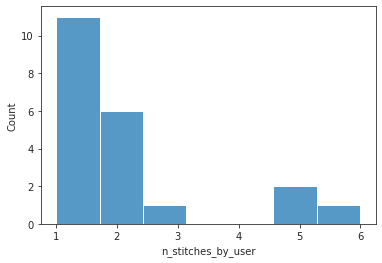

In [55]:
import seaborn as sns
sns.histplot(dfs, x="n_stitches_by_user")

In [43]:
dfs.columns

Index(['filename', 'report_url', 'timestamp', 'email', 'uploaded_at',
       'finished_at', 'fps', 'Needle holder length [m]', 'Scissors length [m]',
       'Forceps length [m]',
       ...
       'Stitch 3 duration [%]', 'Needle holder stitch 0 length [pix]',
       'Forceps stitch 0 length [pix]', 'Scissors stitch 0 length [pix]',
       'Needle holder bbox stitch 0 length [pix]',
       'Forceps bbox stitch 0 length [pix]',
       'Scissors bbox stitch 0 length [pix]',
       'Left hand bbox stitch 0 length [pix]',
       'Right hand bbox stitch 0 length [pix]', 'stars_auto'],
      dtype='object', length=454)

### Replace "," with "."

In [56]:
# find the columns where its values contain single "," and digits
dfs.columns[dfs.apply(lambda x: (x.dtype is str) and (x.str.contains(",\d").any()))]
cols = []
for col in dfs.columns:
    try:
        if (dfs[col].str.contains(",\d").any()):
            # convert , to . and change the column type to float
            dfs[col] = dfs[col].str.replace(",", ".").astype(float)
            cols.append(col)
    except:
        pass
# cols

In [45]:
# dfs

In [46]:
# print name of columns containing needle holder
# dfs.columns[dfs.columns.str.contains("Needle holder")]

In [47]:
# dfs[["Needle holder stitch 1 length [m]", "Needle holder length [m]"]]

### If there is just one stitch, put ths information into stitch 1 measurements

In [48]:
# If column containing " stitch 1" in its name has empty values, fill them with  the values from the column with the same name but withuou " stitch 1"
for col in dfs.columns[dfs.columns.str.contains(" stitch 0")]:
    dfs[col] = dfs[col].fillna(dfs[col.replace(" stitch 0", "")])

In [49]:
# dfs[["Needle holder stitch 1 length [m]", "Needle holder length [m]"]]


# Find the correlation

In [50]:
# dfs.corr()

In [51]:
# find corelation between stars_auto and other numerical columns and sort them
dfs.corr()["stars_auto"].sort_values()



Forceps stitch 1 velocity                  -0.959451
annotation_annotation_stars                -0.944911
n_stitches_by_user                         -0.325079
Scissors bbox stitch 1 visibility [%]      -0.304625
Right hand bbox stitch 0 visibility [%]    -0.289707
                                              ...   
Needle holder bbox stitch 0 length [pix]         NaN
Forceps bbox stitch 0 length [pix]               NaN
Scissors bbox stitch 0 length [pix]              NaN
Left hand bbox stitch 0 length [pix]             NaN
Right hand bbox stitch 0 length [pix]            NaN
Name: stars_auto, Length: 220, dtype: float64

In [52]:
# try to find the best columns to predict stars_auto
corr = dfs.corr()["stars_auto"].sort_values(ascending=False).head(10)
corr


stars_auto                                    1.000000
Scissors bbox stitch 1 area presence [%]      1.000000
Scissors bbox stitch 1 length [m]             0.996787
Forceps stitch 1 visibility [s]               0.985179
Stitch 1 duration [s]                         0.982761
Left hand bbox stitch 1 length [m]            0.945982
Forceps stitch 1 length [m]                   0.936537
Needle holder stitch 1 visibility [s]         0.927372
Right hand bbox stitch 1 area presence [%]    0.912075
Left hand bbox stitch 1 visibility [s]        0.894028
Name: stars_auto, dtype: float64

In [35]:
columns = ["filename", "Needle holder stitch 1 length [m]", "Stitches perpendicular score [%]", "Needle holder stitch 1 visibility [s]", "Stitches parallelism score [%]"]

dfs[columns]

,filename,Needle holder stitch 1 length [m],Stitches perpendicular score [%],Needle holder stitch 1 visibility [s],Stitches parallelism score [%]
870,Good-03_11_2021_B_Holzmu_ller_Katharina_Einzel...,NaN,NaN,NaN,NaN
871,Good-2021_11_03_B_Zu_hl_Amelie_Einzelknopfnaht...,NaN,NaN,NaN,NaN
872,Medium-2021_11_03_A_Seifert_Johanna_Einzelknop...,NaN,NaN,NaN,NaN
874,Medium-2021_11_03_A_Tengler_Sophie_Einzelknopf...,NaN,NaN,NaN,NaN
875,Medium-2021_10_12_B_Westermann_Lammers_Johanna...,NaN,NaN,NaN,NaN
876,Good-Einzelknopfnaht_Stoklossa.mp4,NaN,NaN,NaN,NaN
877,Good-2021_11_17_A_Gramlich_Judith_Stresstest_E...,NaN,NaN,NaN,NaN
878,Good-2021_10_27_B_Etzel_Peter_Einzelknopfnaht_...,NaN,NaN,NaN,NaN
879,Bad-2021_11_3_A_Brodersen___nne_Einzelknopfnah...,NaN,NaN,NaN,NaN
880,Bad-2021_11_03_B_V_lz__Ann_Sophie_Einzelknopfn...,NaN,NaN,NaN,NaN


# Train predictor

In [33]:
import sklearn
# train a model to predict stars_auto
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import SVM
from sklearn.svm import SVR
#train a model to predict stars_auto

# columns = list(corr.index)
columns.append("filename")

dfsx = dfs[columns]
print(len(dfsx))
dfsx = dfsx.dropna()
print(len(dfsx))
X = dfsx[corr.index].drop("stars_auto", axis=1)
y = dfsx["stars_auto"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVR()
model.fit(X_train, y_train)

# 
# X

22
10


KeyError: "['stars_auto', 'Stitch 1 duration [s]', 'Stitch 1 duration [%]', 'Scissors bbox stitch 1 length [m]', 'Scissors bbox stitch 0 length [m]', 'Needle holder stitch 0 length [m]', 'Scissors bbox length [m]'] not in index"

In [22]:
dfsx

,stars_auto,Stitch 1 duration [s],Stitch 1 duration [%],Scissors bbox stitch 1 length [m],Scissors bbox stitch 0 length [m],Stitches perpendicular score [%],Needle holder stitch 0 length [m],Needle holder stitch 1 length [m],Scissors bbox length [m],Needle holder stitch 1 visibility [s],filename
893,2,156.933333,50.743695,2.141051,1.166848,100.000000,2.151528,3.420839,3.526894,125.866667,Bad-03_11_21_B_Hopfe_Johanna_Einzelknopfnaht.mp4
894,0,35.733333,6.513550,0.052302,0.157242,73.333333,0.990121,0.098898,0.999684,27.600000,Good-162880einzelknopf.mp4


## Score

In [19]:
model.score(X_test, y_test)

/home/appuser/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [20]:
model.score(X_train, y_train)

/home/appuser/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

## Check the předictions

In [21]:
y_test

816    2
842    0
840    0
822    2
Name: stars_auto, dtype: int64

In [22]:
y_pred = model.predict(X_test)
y_pred

array([0.12636363, 0.11648296, 0.03380476, 0.10143237])

In [23]:
model.predict(X_train)


array([0.10069563, 0.11084839, 0.09947057, 0.10949899, 0.10615264,
       0.09285266, 0.12814825, 0.11112511, 0.12869557, 0.09870658,
       0.10005963, 0.10915682, 0.10023484, 0.10139677, 0.10023488,
       0.08063209])

In [24]:
y_train

829    0
826    2
833    0
824    2
843    0
841    0
835    2
823    2
830    0
857    2
825    0
834    2
828    0
832    0
839    0
827    0
Name: stars_auto, dtype: int64

In [25]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5

In [26]:
clf.predict(X_train)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [65]:
y_test

816    2
842    0
840    0
822    2
Name: stars_auto, dtype: int32